In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import (layers,callbacks)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    MaxPooling1D,
    Activation,
    LSTM,
    Bidirectional
)

import sklearn as skl
from sklearn import preprocessing
import pandas as pd
import numpy as np

import my_functions as ft # <--- Functions I wrote for the exercise.

all_data = pd.read_csv('all_split_data_concat.csv')

In [2]:
print('The 1000th most common family has '+str(all_data.value_counts('family_id')[1000])+' members.')
print('The 200th most common family has '+str(all_data.value_counts('family_id')[200])+' members.')

The 1000th most common family has 284 members.
The 200th most common family has 730 members.


Ideally we reduce the dataset to about the 1000 most common families.\
For the sake of computational cost we will reduce it to the 200 most common families.\

This truncation removed families which are exceptionally small as the model will learn these very poorly and may lead to bias.\

As shown in the preliminary analysis the dataset has significant imbalance of features such as family size, sequence length and amino acid abundance.

In [3]:
# Cut the dataframe down to the 200 most common families only.
families_to_include_count = 200 # <--- How many to cut down to. This value can easily be changed and will follow through for the entire pipeline.
families_to_include = all_data.value_counts('family_id')[:families_to_include_count].keys().values # <--- Get the amino acid names.
truncated_data = all_data[all_data['family_id'].isin(families_to_include)].reset_index() # <--- Pull out only rows with the most common families.
print('We still have a dataset containing '+str(int(len(truncated_data.index)))+' points\n')
print('This includes '+str(int(len(truncated_data.query('split == "train"').index)))+' points for training')
print('and '+str(int(len(truncated_data.query('split == "test"').index)))+' points for testing')

We still have a dataset containing 195127 points

This includes 156275 points for training
and 19426 points for testing


In [4]:
# Cut up the sequences into a list of amino acid letter codes.
# This is so we can easily convert them into a list if intiegers in preprocessing.
sequences_cut = []
for sequence in truncated_data.sequence:
    sequences_cut.append([*sequence])
truncated_data['sequence_cut'] = sequences_cut # <--- This bit of code cute the sequence up into a list of letters which we can encode.
truncated_data.tail()

,index,family_id,sequence_name,family_accession,aligned_sequence,sequence,split,sequence_cut
195122,1339064,Integrase_H2C2,C5L013_PERM5/1329-1385,PF17921.1,VPEGDRSQALEAAHGD....GHASPERMLRAMMSTVWWPKMSPDID...,VPEGDRSQALEAAHGDGHASPERMLRAMMSTVWWPKMSPDIDAYCS...,test,"[V, P, E, G, D, R, S, Q, A, L, E, A, A, H, G, ..."
195123,1339072,AIRS,F9VEB0_LACGL/446-564,PF00586.24,SD......AA.......................................,SDAAVIRLRHSNKALAMTTDCNARYLYLNPEIGGQIAVAEAARNII...,test,"[S, D, A, A, V, I, R, L, R, H, S, N, K, A, L, ..."
195124,1339076,Ribosomal_L22,F2LXT7_HIPMA/5-106,PF00237.19,AFLRS.AK.ISPIKVREVISLVKG......KSVDEALVLLKY..SN...,AFLRSAKISPIKVREVISLVKGKSVDEALVLLKYSNRKASFILKKL...,test,"[A, F, L, R, S, A, K, I, S, P, I, K, V, R, E, ..."
195125,1339079,F_bP_aldolase,Q5SHF7_THET8/3-304,PF01116.20,VTGLEILRKARAEGY.GVGAFNT.........NNMEFTQAILEAAE...,VTGLEILRKARAEGYGVGAFNTNNMEFTQAILEAAEEMKSPVILAL...,test,"[V, T, G, L, E, I, L, R, K, A, R, A, E, G, Y, ..."
195126,1339082,Beta-Casp,A4CMY8_ROBBH/252-370,PF10996.8,.QAIMLIL....LKLR.QR...NR.........................,QAIMLILLKLRQRNRIPRLPVYIDSPMGTNVFELFGRFPNWHKLSR...,test,"[Q, A, I, M, L, I, L, L, K, L, R, Q, R, N, R, ..."


In [5]:
# Get the training and test features and targets.
features_train = truncated_data.query('split == "train"').sequence_cut
target_train = truncated_data.query('split == "train"').family_accession

features_test = truncated_data.query('split == "test"').sequence_cut
target_test = truncated_data.query('split == "test"').family_accession

In [6]:
# Fit an encoder do encoding out test data. This only needs to be fit to the training data as it contains all the test data amino acids.
label_ = preprocessing.LabelEncoder()
label_.fit(target_train)
# Then transform the target data.
target_train = label_.transform(target_train)   # <--- Transform catagorical data to numerical so that a model can interprate it.
                                                # e.g. if...
                                                # y = ['C','A','P','C','A']
                                                #   label_.transform(y)
                                                # y_encoded = [0,1,2,0,1]
target_test = label_.transform(target_test)
target_test

array([ 90, 183,   7, ...,   7,  49, 170])

In [7]:
# Take the data from a integer representation to a one-hot representation. Integer representation can imply a hierarchy which does not exist to the model.
target_train = tf.keras.utils.to_categorical(target_train)  # <--- Transform classes to one-hot representation.
                                                            # e.g. if... 
                                                            # y = [0, 2, 1, 1]
                                                            #   tf.keras.utils.to_categorical(y)
                                                            # y_one-hot = [1,0,0]
                                                            #             [0,0,1]
                                                            #             [0,1,0]
                                                            #             [0,1,0]
target_test = tf.keras.utils.to_categorical(target_test)

In [8]:
# The Tokenizer takes a maximum number of words and converts them to numerical tokens. In this case, our amino acid letter codes.
tokenizer_num_words = 2000
tokenizer_seq = Tokenizer(num_words = tokenizer_num_words) # <--- Initialise Tokenizer with a maximum of 2000 word token to convert to intigers. We don't need that many.
tokenizer_seq.fit_on_texts(features_train) # <--- Fit the tokens to out dataset features.
print('The substitutions made...')
print(tokenizer_seq.word_index)

The substitutions made...
{'l': 1, 'a': 2, 'g': 3, 'v': 4, 'i': 5, 'e': 6, 's': 7, 'd': 8, 'r': 9, 'k': 10, 't': 11, 'p': 12, 'f': 13, 'n': 14, 'q': 15, 'y': 16, 'm': 17, 'h': 18, 'c': 19, 'w': 20, 'x': 21, 'u': 22, 'b': 23}


In [9]:
# Uset the token codes to convert our amino acid lists to lists of numerical tokens instead.
features_train = tokenizer_seq.texts_to_sequences(features_train)
features_test = tokenizer_seq.texts_to_sequences(features_test)

In [10]:
# Here, we pad the sequences so that the feature data is all the same shape. This is important for efficiency of out model.
max_length = 100
features_train = pad_sequences(features_train,maxlen=max_length,padding='post',truncating='post')
    # maxlen - Make sure all feature entries are the same shape.
    # padding='post' - Ensures padding is added to the end of the matrix.
    # truncating='post' - Ensures that elements beyond the maximum length are truncated at the same end as padding.
features_test = pad_sequences(features_test,maxlen=max_length,padding='post',truncating='post')

In [11]:
# Input paramtered for the model.
optimizer = 'adam'
loss = 'categorical_crossentropy'
# categorical_crossentropy - As there are more than two categories we use this loss function. 
# If there were only two we would use binary_crossentropy.
# If we were using numerical representation we would use sparse_categorical_crossentropy
metrics = ["categorical_accuracy"]
vocab = ft.acid_list
dropout_ratio = 0.2
embedding_size = 100
X_train = features_train
y_train = target_train
X_test = features_test
y_test = target_test

In [12]:
# Based on the model used by Henrik Åhl for pfam classification.
#   https://www.kaggle.com/code/henrikhl/pfam-classification#Model-formulation
model = keras.Sequential() # <--- The sequential class initialises a model with a linear stack of layers.
model.add(layers.Embedding(len(vocab),embedding_size,input_length=max_length))
    # Embedding is necessary to represent natural language as high dimension vectors.
    # This allows the model to explain relationships between amino acids in out sequences and how they may determine the catagorisation.
model.add(Dropout(dropout_ratio))
    # Dropout will randomly drop node connections to prevent over fitting of the training data.
    # This helps to stop single nodes having large influence on the output.
model.add(Conv1D(filters=64, kernel_size=16, padding="same"))
    # This layer applies a window to the 1D data sequence.
    # This allows it to identify local patterns in the sequence which may pertain to certain families.
model.add(Activation('leaky_relu')) # <--- Leaky ReLU prevents 'dying ReLU' where negative inputs result in nodes only outputting 0.
    # Activation applies some function to the input data in order to generate the output.
    # This allows for modelling more complicated relationships as the activation function can apply non-linear transformations.
model.add(Dropout(dropout_ratio))
model.add(BatchNormalization())
    # Batch normalization is exactly what it sounds like.
    # Each input is scaled to prevent exceptionally large or small activation gradients.
    # This also benefits other acpects such as overfitting and performance.
model.add(MaxPooling1D(pool_size=3))
    # Similar to Conv1D a window is applied.
    # The sum of the window is taken as the output.
model.add(Bidirectional(LSTM(64, dropout=dropout_ratio, recurrent_dropout=dropout_ratio)))
    # Bidirectional LSTM allows the netwrok to process forward and backward.
model.add(BatchNormalization())
model.add(Flatten())
    # This layer takes a multidimensional input and flattens it to a 1D tensor.
    # This is necessary as the following layer will classify the output into one of the classes.
model.add(Dense(families_to_include_count, activation="softmax"))
    # Classify the output as one of the protein families.
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    # Compile the model so that it can then be applied.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2400      
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           102464    
                                                                 
 activation (Activation)     (None, 100, 64)           0         
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 batch_normalization (BatchN  (None, 100, 64)          256       
 ormalization)                                                   
                                                        

In [13]:
es = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
    # Early stopping is used to prevent overfitting.
    # This will stop the model is the training and validation loss diverge.

history = model.fit(
    X_train, # <--- Training features.
    y_train, # <--- Training labels.
    epochs=10, # <--- Repeats on the training set to run
    batch_size=256, # <--- How many datapoints to include in each epoch.
    validation_data=(X_test, y_test), # <--- Validation data.
    callbacks=[es] # <--- Early stopping method.
)

Epoch 1/10
611/611 [==============================] - 187s 295ms/step - loss: 0.9660 - categorical_accuracy: 0.8332 - val_loss: 0.1812 - val_categorical_accuracy: 0.9699
Epoch 2/10
611/611 [==============================] - 175s 286ms/step - loss: 0.1042 - categorical_accuracy: 0.9797 - val_loss: 0.0541 - val_categorical_accuracy: 0.9877
Epoch 3/10
611/611 [==============================] - 166s 272ms/step - loss: 0.0565 - categorical_accuracy: 0.9878 - val_loss: 0.0354 - val_categorical_accuracy: 0.9917
Epoch 4/10
611/611 [==============================] - 165s 270ms/step - loss: 0.0376 - categorical_accuracy: 0.9914 - val_loss: 0.0293 - val_categorical_accuracy: 0.9930
Epoch 5/10
611/611 [==============================] - 173s 283ms/step - loss: 0.0280 - categorical_accuracy: 0.9933 - val_loss: 0.0291 - val_categorical_accuracy: 0.9914
Epoch 6/10
611/611 [==============================] - 167s 273ms/step - loss: 0.0231 - categorical_accuracy: 0.9939 - val_loss: 0.0201 - val_categoric

In [20]:
history_df

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,0.965993,0.833192,0.181156,0.969886
1,0.104163,0.979722,0.054115,0.987697
2,0.056455,0.987836,0.035368,0.991712
3,0.037590,0.991406,0.029274,0.992999
4,0.028002,0.993294,0.029107,0.991403
5,0.023147,0.993940,0.020055,0.994132
6,0.018388,0.995258,0.016463,0.996191
7,0.016584,0.995546,0.014664,0.995882
8,0.012915,0.996596,0.015758,0.995676
9,0.012427,0.996557,0.016372,0.995521


Index(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'], dtype='object')


<Axes: title={'center': 'Loss (blue) vs validation loss (orange)'}, xlabel='Epochs', ylabel='Loss'>

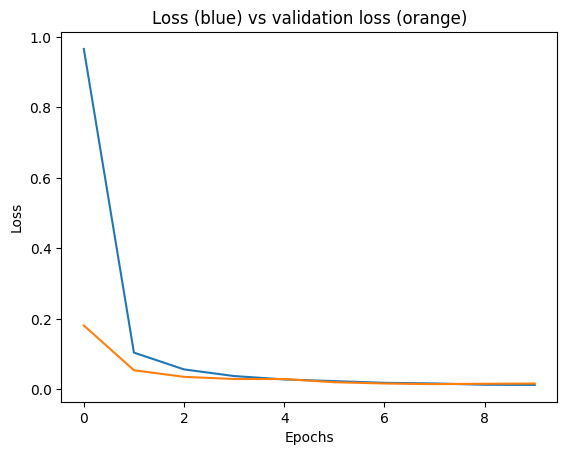

In [24]:
history_df = pd.DataFrame(history.history)
print(history_df.columns)
history_df[history_df.columns[0]].plot()
history_df[history_df.columns[2]].plot(title='Loss (blue) vs validation loss (orange)',xlabel='Epochs',ylabel='Loss')

<Axes: title={'center': 'Categorical accuracy (blue) vs categorical validation accuracy (orange)'}, xlabel='Epochs', ylabel='Loss'>

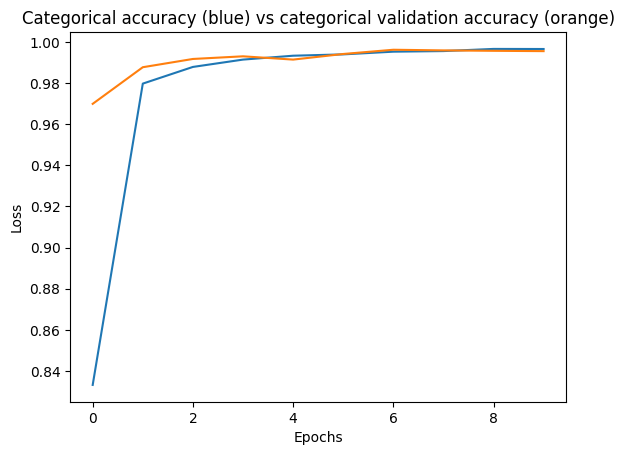

In [26]:
history_df[history_df.columns[1]].plot()
history_df[history_df.columns[3]].plot(title='Categorical accuracy (blue) vs categorical validation accuracy (orange)',xlabel='Epochs',ylabel='Loss')

This shows we have good convergence of loss and accuracy in the validation set with training set as we run the model over 10 epochs.\